TODO: add context and problem statement etc.

## Import modules and data

In [1]:
import os
import pickle

import warnings
from datetime import datetime, timedelta
from time import time

import joblib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score

from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor

warnings.filterwarnings("ignore")
pd.set_option(
    "display.max_columns", None
)  # displays all columns (wrap-around) in pandas statistics

I0825 091458.785 font_manager.py:1550] generated new fontManager


In [2]:
file_paths = {
    "orders_train": "/data/sandcastle/boxes/configerator/source/parin_course/Ecommerce_Order_Dataset/train/df_Orders.csv",
    "customers_train": "/data/sandcastle/boxes/configerator/source/parin_course/Ecommerce_Order_Dataset/train/df_Customers.csv",
    "products_train": "/data/sandcastle/boxes/configerator/source/parin_course/Ecommerce_Order_Dataset/train/df_Products.csv",
    "payments_train": "/data/sandcastle/boxes/configerator/source/parin_course/Ecommerce_Order_Dataset/train/df_Payments.csv",
    "order_items_train": "/data/sandcastle/boxes/configerator/source/parin_course/Ecommerce_Order_Dataset/train/df_OrderItems.csv",
    "orders_test": "/data/sandcastle/boxes/configerator/source/parin_course/Ecommerce_Order_Dataset/test/df_Orders.csv",
    "customers_test": "/data/sandcastle/boxes/configerator/source/parin_course/Ecommerce_Order_Dataset/test/df_Customers.csv",
    "products_test": "/data/sandcastle/boxes/configerator/source/parin_course/Ecommerce_Order_Dataset/test/df_Products.csv",
    "payments_test": "/data/sandcastle/boxes/configerator/source/parin_course/Ecommerce_Order_Dataset/test/df_Payments.csv",
    "order_items_test": "/data/sandcastle/boxes/configerator/source/parin_course/Ecommerce_Order_Dataset/test/df_OrderItems.csv",
}

# Load datasets
df_orders_train = pd.read_csv(file_paths["orders_train"])
df_customers_train = pd.read_csv(file_paths["customers_train"])
df_products_train = pd.read_csv(file_paths["products_train"])
df_payments_train = pd.read_csv(file_paths["payments_train"])
df_order_items_train = pd.read_csv(file_paths["order_items_train"])

df_orders_test = pd.read_csv(file_paths["orders_test"])
df_customers_test = pd.read_csv(file_paths["customers_test"])
df_products_test = pd.read_csv(file_paths["products_test"])
df_payments_test = pd.read_csv(file_paths["payments_test"])
df_order_items_test = pd.read_csv(file_paths["order_items_test"])

# Display the first few rows of each dataframe to understand the structure
print("Orders (Train):")
display(df_orders_train.head())

print("Customers (Train):")
display(df_customers_train.head())

print("Products (Train):")
display(df_products_train.head())

print("Payments (Train):")
display(df_payments_train.head())

print("Order Items (Train):")
display(df_order_items_train.head())

Orders (Train):
Customers (Train):
Products (Train):
Payments (Train):
Order Items (Train):


,order_id,product_id,seller_id,price,shipping_charges
0,Axfy13Hk4PIk,90K0C1fIyQUf,ZWM05J9LcBSF,223.51,84.65
1,v6px92oS8cLG,qejhpMGGVcsl,IjlpYfhUbRQs,170.80,23.79
2,Ulpf9skrhjfm,qUS5d2pEAyxJ,77p2EYxcM9MD,64.40,17.38
3,bwJVWupf2keN,639iGvMyv0De,jWzS0ayv9TGf,264.50,30.72
4,Dd0QnrMk9Cj5,1lycYGcsic2F,l1pYW6GBnPMr,779.90,30.66


## Train data inspection and data cleaning

In [3]:
# null values
def print_null_duplicates(df):
    print("Null values:")
    print(df.isnull().sum())
    print("Duplicate values:")
    print(df.duplicated().sum())


print("\nOrders (Train):")
print_null_duplicates(df_orders_train)

print("\nCustomers (Train):")
print_null_duplicates(df_customers_train)

print("\nProducts (Train):")
print_null_duplicates(df_products_train)

print("\nPayments (Train):")
print_null_duplicates(df_payments_train)

print("\nOrder Items (Train):")
print_null_duplicates(df_order_items_train)


Orders (Train):
Null values:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                   9
order_delivered_timestamp        1889
order_estimated_delivery_date       0
dtype: int64
Duplicate values:
0

Customers (Train):
Null values:
customer_id                 0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64
Duplicate values:
0

Products (Train):
Null values:
product_id                 0
product_category_name    308
product_weight_g          15
product_length_cm         15
product_height_cm         15
product_width_cm          15
dtype: int64
Duplicate values:
61865

Payments (Train):
Null values:
order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64
Duplicate values:
0

Order Items (Train):
Null values:
order_id    

### Orders dataset

In [4]:
df_orders_train.info()
print(df_orders_train.duplicated(subset=["order_id"]).value_counts())
print(df_orders_train.duplicated(subset=["customer_id"]).value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89316 entries, 0 to 89315
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       89316 non-null  object
 1   customer_id                    89316 non-null  object
 2   order_status                   89316 non-null  object
 3   order_purchase_timestamp       89316 non-null  object
 4   order_approved_at              89307 non-null  object
 5   order_delivered_timestamp      87427 non-null  object
 6   order_estimated_delivery_date  89316 non-null  object
dtypes: object(7)
memory usage: 4.8+ MB
False    89316
Name: count, dtype: int64
False    89316
Name: count, dtype: int64


Insights:
* This can be merged with customers dateset
* Following columns are unnecessary
  * order_purchase_timestamp
  * order_approved_at
  * order_delivered_timestamp
  * order_estimated_delivery_date
* After merge the ID columns can be dropped from the training datasets

### Customers dataset

In [5]:
df_customers_train.info()
print(df_customers_train.duplicated(subset=["customer_id"]).value_counts())
print(df_customers_train["customer_city"].unique().size)
print(df_customers_train["customer_state"].unique().size)
print(df_customers_train["customer_zip_code_prefix"].sample(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89316 entries, 0 to 89315
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               89316 non-null  object
 1   customer_zip_code_prefix  89316 non-null  int64 
 2   customer_city             89316 non-null  object
 3   customer_state            89316 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.7+ MB
False    89316
Name: count, dtype: int64
3735
27
1382     18108
3973     93135
34028    35495
30189    14030
52868    72596
32820    72546
70756    23028
20722    40421
84025    28634
40509    37795
Name: customer_zip_code_prefix, dtype: int64


Insights
* customer_zip_code_prefix is unnecessary and can be dropped
* This can be merged with orders dataset

### Products dataset

In [6]:
print(df_products_train.info())
# removing duplicates from products dataset
# df_products_train = df_products_train.drop_duplicates()
print_null_duplicates(df_products_train)
print(df_products_train["product_category_name"].unique().size)
print(df_products_train["product_category_name"].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89316 entries, 0 to 89315
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   product_id             89316 non-null  object 
 1   product_category_name  89008 non-null  object 
 2   product_weight_g       89301 non-null  float64
 3   product_length_cm      89301 non-null  float64
 4   product_height_cm      89301 non-null  float64
 5   product_width_cm       89301 non-null  float64
dtypes: float64(4), object(2)
memory usage: 4.1+ MB
None
Null values:
product_id                 0
product_category_name    308
product_weight_g          15
product_length_cm         15
product_height_cm         15
product_width_cm          15
dtype: int64
Duplicate values:
61865
71
['toys' 'watches_gifts' 'costruction_tools_garden' 'bed_bath_table' 'auto'
 'health_beauty' 'cool_stuff' 'garden_tools' 'furniture_decor'
 'fashion_shoes' 'sports_leisure' 'baby' 'housewares'


Insights:
* We can remove the duplicate rows from the dataset
* Marginal number of rows have product_category_name as nan
  * We would still keep them in case some of those products are very popular

### Order items dataset

In [7]:
print(df_order_items_train.info())
print(df_order_items_train.duplicated(subset=["order_id"]).value_counts())
print(df_order_items_train.duplicated(subset=["product_id"]).value_counts())
print(df_order_items_train.duplicated(subset=["seller_id"]).value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89316 entries, 0 to 89315
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   order_id          89316 non-null  object 
 1   product_id        89316 non-null  object 
 2   seller_id         89316 non-null  object 
 3   price             89316 non-null  float64
 4   shipping_charges  89316 non-null  float64
dtypes: float64(2), object(3)
memory usage: 3.4+ MB
None
False    89316
Name: count, dtype: int64
True     61865
False    27451
Name: count, dtype: int64
True     86387
False     2929
Name: count, dtype: int64


In [8]:
# df_order_items_train["price"].hist(column="price", bins=500, figsize=(15, 8))

In [9]:
# df_order_items_train["shipping_charges"].hist(
#     column="shipping_charges", bins=500, figsize=(15, 8)
# )

Insights:
* Seller id is unnecessary
* This dataset can be merged with orders dataset
* Once merged, the id columns can be dropped

### Payments dataset

In [10]:
print(df_payments_train.info())
print(df_payments_train.duplicated(subset=["order_id"]).value_counts())
print(df_payments_train["payment_type"].unique())
print(df_payments_train["payment_sequential"].unique())
print(df_payments_train["payment_installments"].unique())

# df_payments_train["payment_value"].hist(
#     column="payment_value", bins=500, figsize=(15, 8)
# )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89316 entries, 0 to 89315
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   order_id              89316 non-null  object 
 1   payment_sequential    89316 non-null  int64  
 2   payment_type          89316 non-null  object 
 3   payment_installments  89316 non-null  int64  
 4   payment_value         89316 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 3.4+ MB
None
False    89316
Name: count, dtype: int64
['credit_card' 'wallet' 'voucher' 'debit_card']
[ 1  8  2  6  3  4  9  5 23 11 18 10  7 12 13 26 15 14 17 24 21 20 16 19
 22 29 25 28]
[ 1  8  4  2  5  6 10  3  7  9 18 12 24 15 11 13 21 16 20 14 17 23 22  0]


Insights:
* Since all orders are unique, this can be merged with the orders table as well

#### Clean datasets

In [11]:
def clean_orders_dataset(df):
    df.drop_duplicates(inplace=True)
    df.drop(
        columns=[
            "order_purchase_timestamp",
            "order_approved_at",
            "order_delivered_timestamp",
            "order_estimated_delivery_date",
        ],
        inplace=True,
    )


def clean_customers_dataset(df):
    df.drop_duplicates(inplace=True)
    df.drop(columns=["customer_zip_code_prefix"], inplace=True)


def clean_products_dataset(df):
    df.drop_duplicates(inplace=True)


def clean_order_items_dataset(df):
    df.drop_duplicates(inplace=True)
    df.drop(columns=["seller_id"], inplace=True)


def clean_payments_dataset(df):
    df.drop_duplicates(inplace=True)

In [12]:
# clean train datasets
clean_orders_dataset(df_orders_train)
clean_customers_dataset(df_customers_train)
clean_products_dataset(df_products_train)
clean_order_items_dataset(df_order_items_train)
clean_payments_dataset(df_payments_train)

### Merge datasets

In [13]:
def merge_datasets(df_orders, df_order_items, df_customers, df_products, df_payments):
    return (
        df_orders.merge(df_order_items, on="order_id", how="outer")
        .merge(df_customers, on="customer_id", how="outer")
        .merge(df_products, on="product_id", how="outer")
        .merge(df_payments, on="order_id", how="outer")
    )


df = merge_datasets(
    df_orders_train,
    df_order_items_train,
    df_customers_train,
    df_products_train,
    df_payments_train,
)
df.info()
print_null_duplicates(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89316 entries, 0 to 89315
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   order_id               89316 non-null  object 
 1   customer_id            89316 non-null  object 
 2   order_status           89316 non-null  object 
 3   product_id             89316 non-null  object 
 4   price                  89316 non-null  float64
 5   shipping_charges       89316 non-null  float64
 6   customer_city          89316 non-null  object 
 7   customer_state         89316 non-null  object 
 8   product_category_name  89008 non-null  object 
 9   product_weight_g       89301 non-null  float64
 10  product_length_cm      89301 non-null  float64
 11  product_height_cm      89301 non-null  float64
 12  product_width_cm       89301 non-null  float64
 13  payment_sequential     89316 non-null  int64  
 14  payment_type           89316 non-null  object 
 15  pa

In [14]:
df.drop(columns=["order_id", "customer_id", "product_id"], inplace=True)

In [15]:
print_null_duplicates(df)

Null values:
order_status               0
price                      0
shipping_charges           0
customer_city              0
customer_state             0
product_category_name    308
product_weight_g          15
product_length_cm         15
product_height_cm         15
product_width_cm          15
payment_sequential         0
payment_type               0
payment_installments       0
payment_value              0
dtype: int64
Duplicate values:
12315


In [17]:
# it seems removing the various id columns resulted in lots of duplicates. Dropping those duplicates now
df.drop_duplicates(inplace=True)
print_null_duplicates(df)

Null values:
order_status               0
price                      0
shipping_charges           0
customer_city              0
customer_state             0
product_category_name    262
product_weight_g          14
product_length_cm         14
product_height_cm         14
product_width_cm          14
payment_sequential         0
payment_type               0
payment_installments       0
payment_value              0
dtype: int64
Duplicate values:
0


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 77001 entries, 0 to 89315
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   order_status           77001 non-null  object 
 1   price                  77001 non-null  float64
 2   shipping_charges       77001 non-null  float64
 3   customer_city          77001 non-null  object 
 4   customer_state         77001 non-null  object 
 5   product_category_name  76739 non-null  object 
 6   product_weight_g       76987 non-null  float64
 7   product_length_cm      76987 non-null  float64
 8   product_height_cm      76987 non-null  float64
 9   product_width_cm       76987 non-null  float64
 10  payment_sequential     77001 non-null  int64  
 11  payment_type           77001 non-null  object 
 12  payment_installments   77001 non-null  int64  
 13  payment_value          77001 non-null  float64
dtypes: float64(7), int64(2), object(5)
memory usage: 8.8+ MB


In [20]:
# reseting the index
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77001 entries, 0 to 77000
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   order_status           77001 non-null  object 
 1   price                  77001 non-null  float64
 2   shipping_charges       77001 non-null  float64
 3   customer_city          77001 non-null  object 
 4   customer_state         77001 non-null  object 
 5   product_category_name  76739 non-null  object 
 6   product_weight_g       76987 non-null  float64
 7   product_length_cm      76987 non-null  float64
 8   product_height_cm      76987 non-null  float64
 9   product_width_cm       76987 non-null  float64
 10  payment_sequential     77001 non-null  int64  
 11  payment_type           77001 non-null  object 
 12  payment_installments   77001 non-null  int64  
 13  payment_value          77001 non-null  float64
dtypes: float64(7), int64(2), object(5)
memory usage: 8.2+ 

In [21]:
df.head()

,order_status,price,shipping_charges,customer_city,customer_state,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm,payment_sequential,payment_type,payment_installments,payment_value
0,delivered,223.51,84.65,varzea paulista,SP,toys,491.0,19.0,12.0,16.0,1,credit_card,1,259.14
1,delivered,223.51,48.35,rio de janeiro,RJ,toys,491.0,19.0,12.0,16.0,1,wallet,1,294.17
2,delivered,223.51,84.65,aracatuba,SP,toys,491.0,19.0,12.0,16.0,1,credit_card,7,259.14
3,delivered,223.51,84.65,araraquara,SP,toys,491.0,19.0,12.0,16.0,1,credit_card,1,259.14
4,delivered,223.51,45.50,cuiaba,MT,toys,491.0,19.0,12.0,16.0,1,credit_card,1,188.63


### Exploratory data analysis

#### Univariate analysis

##### Numeric features

array([[<Axes: title={'center': 'price'}>,
        <Axes: title={'center': 'shipping_charges'}>,
        <Axes: title={'center': 'product_weight_g'}>],
       [<Axes: title={'center': 'product_length_cm'}>,
        <Axes: title={'center': 'product_height_cm'}>,
        <Axes: title={'center': 'product_width_cm'}>],
       [<Axes: title={'center': 'payment_sequential'}>,
        <Axes: title={'center': 'payment_installments'}>,
        <Axes: title={'center': 'payment_value'}>]], dtype=object)

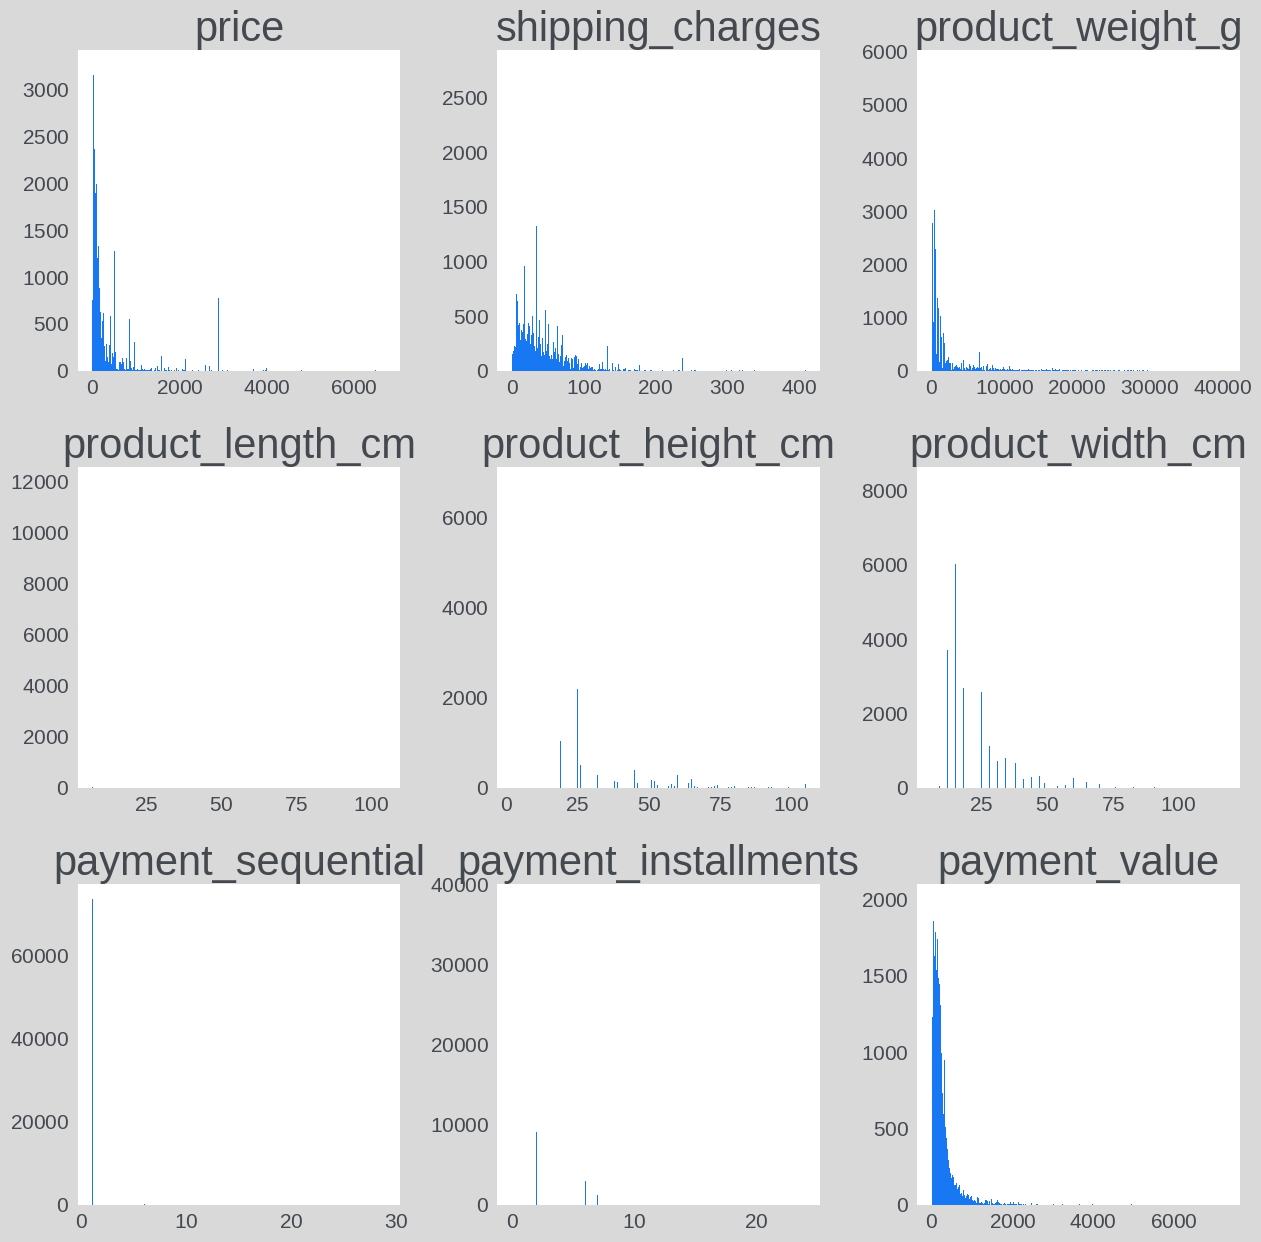

In [44]:
df.hist(figsize=(15, 15), grid=False, bins=1000)

##### Categorical features

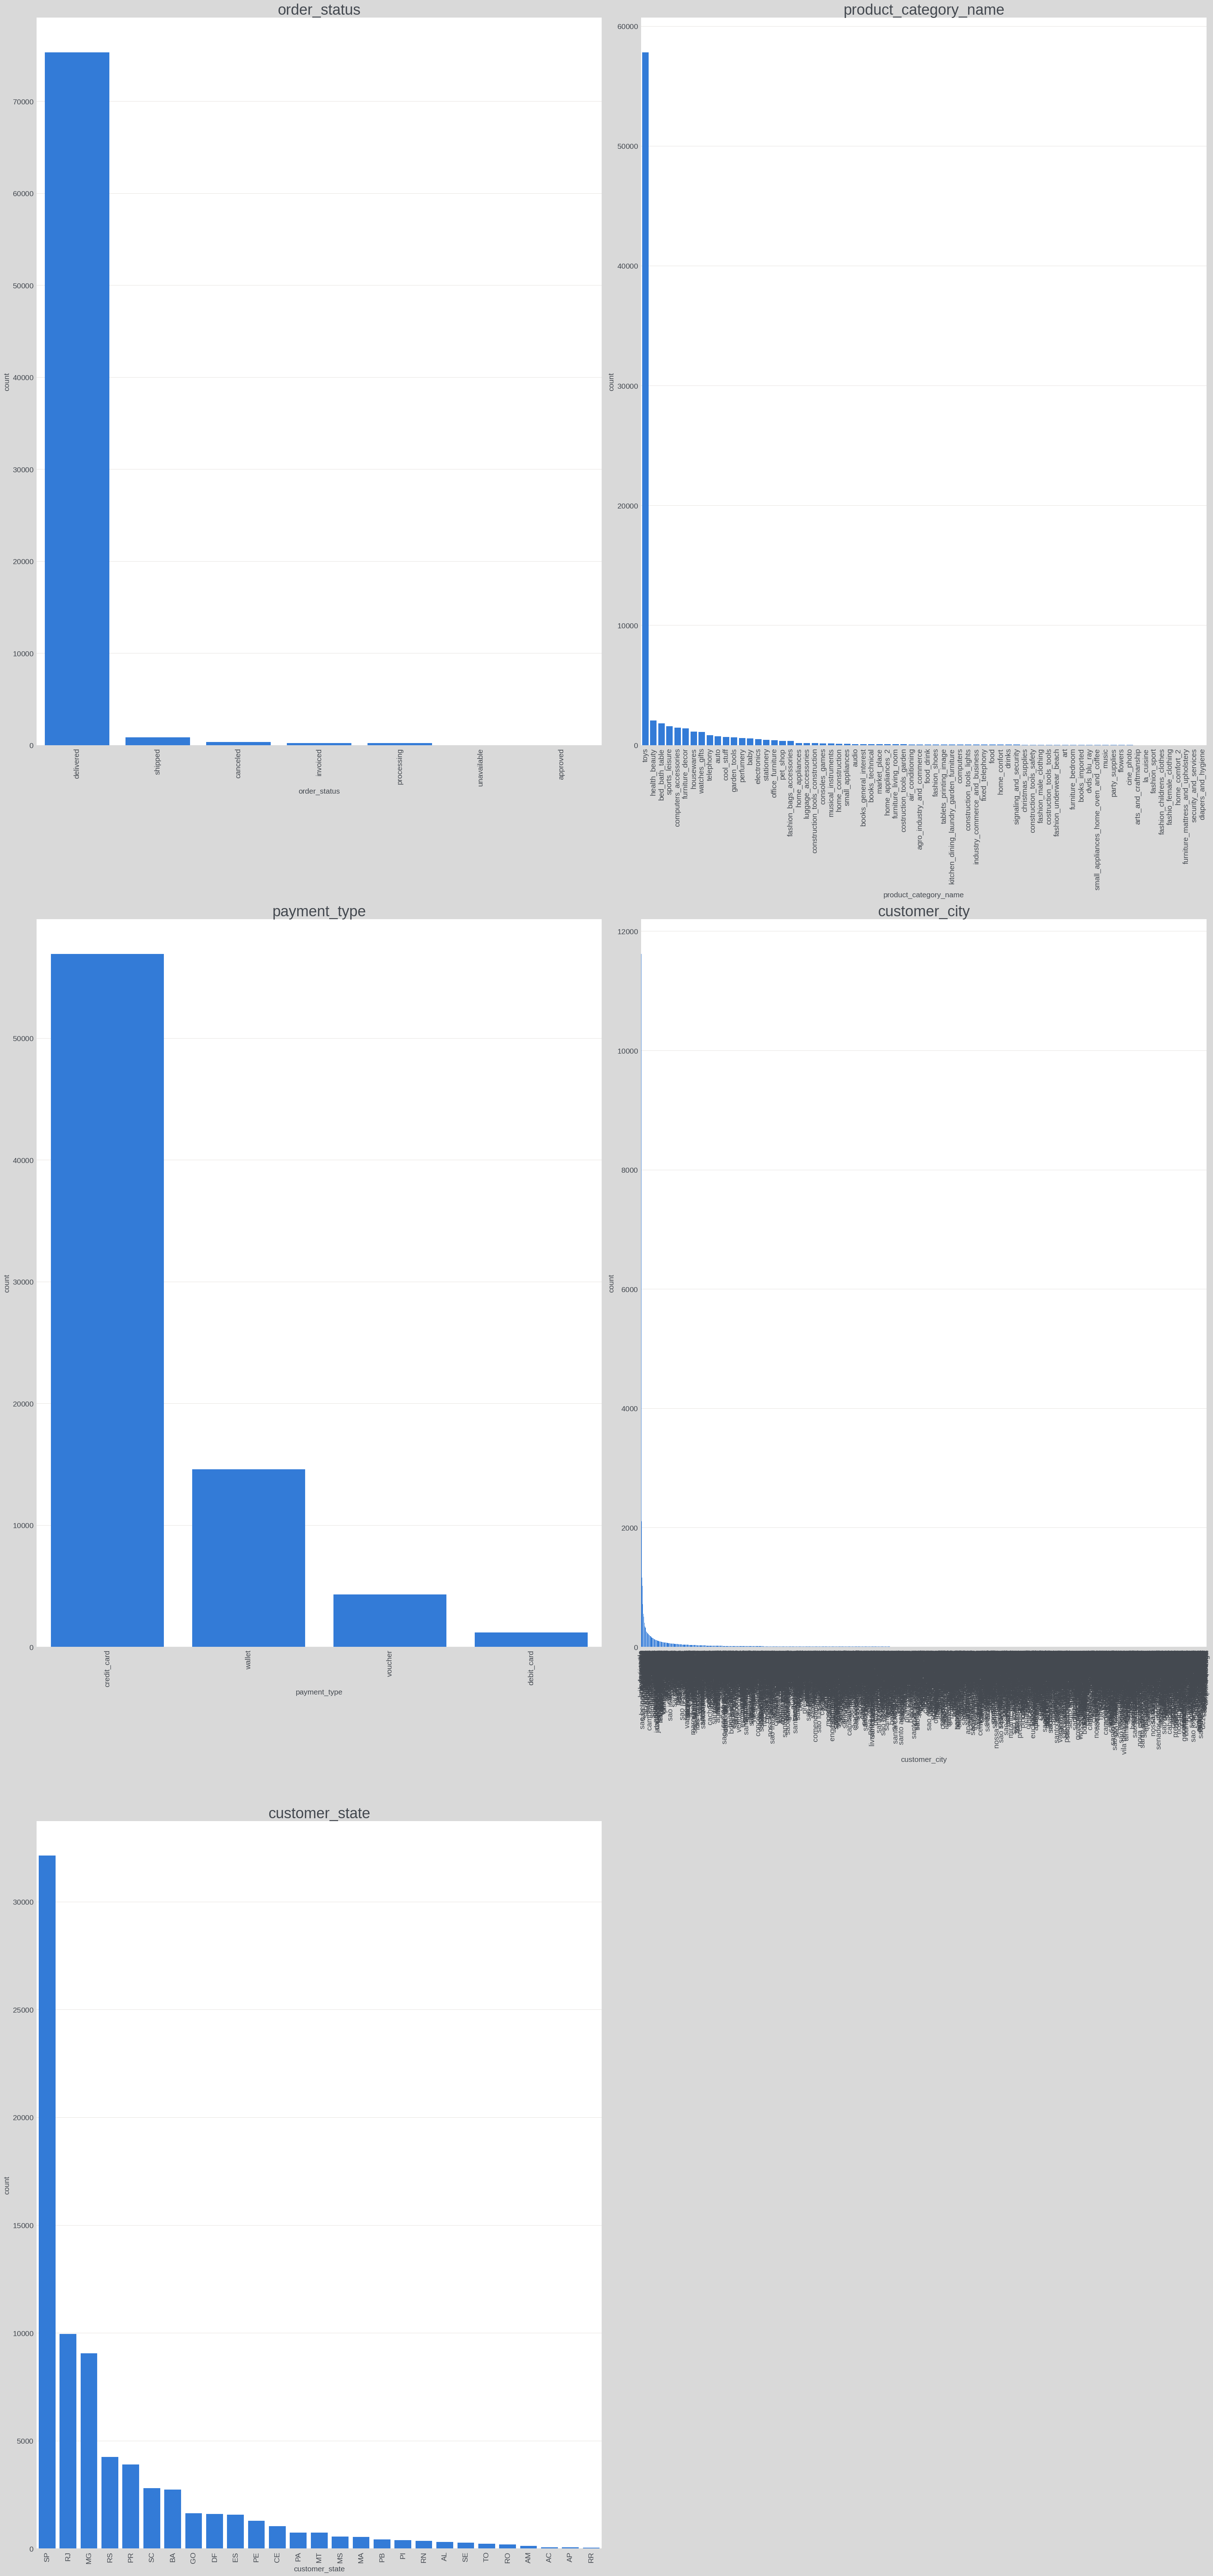

In [47]:
n_categories = 5
n_cols = 2
n_rows = n_categories // n_cols + (n_categories % n_cols > 0)
cat = df[
    [
        "order_status",
        "product_category_name",
        "payment_type",
        "customer_state",
        "customer_city",
    ]
]
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 17, n_rows * 24))
axs = axs.flatten()
for i, column in enumerate(cat.columns):
    # Plot each category in its subplot
    sns.barplot(
        x=cat[column].value_counts().index, y=cat[column].value_counts(), ax=axs[i]
    )
    axs[i].set_title(column)
    # Get current x-tick labels and set them with a 90-degree rotation
    labels = axs[i].get_xticklabels()
    axs[i].set_xticklabels(labels, rotation=90)

for i in range(n_categories, len(axs)):
    axs[i].set_visible(False)
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

In [42]:
# df['product_category_name'].value_counts().plot(kind='bar')
# df[df['payment_type']=='credit_card'].groupby('product_category_name')['payment_type'].count().sort_values().plot(kind='bar', title='test')

In [43]:
# df[df['payment_type']=='wallet'].groupby('customer_city')['payment_type'].count().sort_values().plot(kind='bar', title='test')